In [1]:
#import required libraries for computer vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [2]:
#make sure pytorch is using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#load data
data_path = '/home/nathan/Desktop/pipetteFocusData/'

#load images and labels using glob
images = glob.glob(data_path + '*.png')
labels = glob.glob(data_path + '*.txt')

#sort images and labels
images.sort()
labels.sort()

#load images and labels into lists
images_list = []
labels_list = []

for image in images:
    img = cv2.imread(image)

    #reshape image to 224x224
    img = cv2.resize(img, (512, 512))

    #equalize histogram
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.equalizeHist(img)
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    #normalize 16 bit image to 8 bit
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    #convert to tensor
    img = torch.from_numpy(img)

    images_list.append(img)

for label in labels:
    with open(label, 'r') as f:
        lines = f.readlines()[0]
        labels_list.append(int(lines))

# #merge classes 0, 1, and 7 into class 0 (in focus)
# for i in range(len(labels_list)):
#     if labels_list[i] == 1 or labels_list[i] == 7:
#         labels_list[i] = 0

# #merge classes 2, and 3 into class 1 (slightly out of focus (above))
# for i in range(len(labels_list)):
#     if labels_list[i] == 2 or labels_list[i] == 3:
#         labels_list[i] = 1
    
# #merge classes 4 and 5 into class 2 (more out of focus (above))
# for i in range(len(labels_list)):
#     if labels_list[i] == 4 or labels_list[i] == 5:
#         labels_list[i] = 2

# #convert class 6 to class 3 (very out of focus (above))
# for i in range(len(labels_list)):
#     if labels_list[i] == 6:
#         labels_list[i] = 3

# #merge classes 8 and 9 into class 4 (slighly out of focus (below))
# for i in range(len(labels_list)):
#     if labels_list[i] == 8 or labels_list[i] == 9:
#         labels_list[i] = 4

# #merge classes 10 and 11 into class 5 (more out of focus (below))
# for i in range(len(labels_list)):
#     if labels_list[i] == 10 or labels_list[i] == 11:
#         labels_list[i] = 5

# #convert class 12 to class 6 (very out of focus (above))
# for i in range(len(labels_list)):
#     if labels_list[i] == 12:
#         labels_list[i] = 6

# #convert class 13 to class 7 (background - no pipette)
# for i in range(len(labels_list)):
#     if labels_list[i] == 13:
#         labels_list[i] = 7

#randomize images and labels
c = list(zip(images_list, labels_list))
np.random.shuffle(c)
images_list, labels_list = zip(*c)

#convert lists to tensors
images_list = torch.stack(images_list)
labels_list = torch.tensor(labels_list)

In [4]:
#split into train and test sets
train_images = images_list[:int(len(images_list)*0.8)]
train_labels = labels_list[:int(len(labels_list)*0.8)]

test_images = images_list[int(len(images_list)*0.8):]
test_labels = labels_list[int(len(labels_list)*0.8):]

tensor(13)


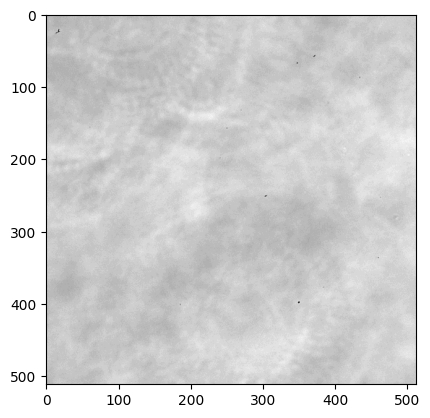

In [5]:
#show a random image and label from test set
rand = np.random.randint(0, len(test_images))
img = test_images[rand]

plt.imshow(img)
print(test_labels[rand])

tensor(7)


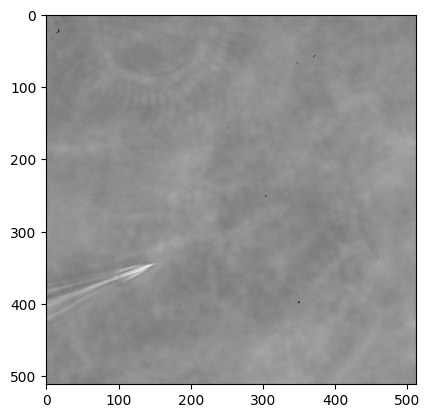

In [6]:
#show a random image and label from train set
rand = np.random.randint(0, len(train_images))
plt.imshow(train_images[rand])
print(train_labels[rand])

In [7]:
#properly format dataset for resnet18
train_images = train_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

#fix labels for cross entropy loss
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

#convert to long
test_labels = test_labels.long()
train_labels = train_labels.long()

#labels are given as numbers (0-7)
# 0 - in focus
# 1 - slightly out of focus (above)
# 2 - more out of focus (above)
# 3 - very out of focus (above)
# 4 - slightly out of focus (below)
# 5 - more out of focus (below)
# 6 - very out of focus (below)
# 7 - background (no pipette)

In [8]:
#retrain resnet18 for 14 class classification
model = models.resnet18(pretrained=True)

#replace first layer with 3 channel input
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

#replace last layer with 14 class classification
model.fc = nn.Linear(512, 14)

#move model to GPU
model = model.to(device)

/home/nathan/miniconda3/envs/holypipette/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nathan/miniconda3/envs/holypipette/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#setup optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
#create data augmentation transforms including normalization and noise, convert to grayscale
train_transforms = torchvision.transforms.Compose([
    #random blur
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.1),
    # #random horizontal flip
    # # #random vertical flip
    # # torchvision.transforms.RandomVerticalFlip(p=0.5),
    # # #add random rotation
    torchvision.transforms.RandomRotation((-3, 3)),

    #add random brightness
    torchvision.transforms.ColorJitter(brightness=0.3),
    # #add random contrast
    torchvision.transforms.ColorJitter(contrast=0.3),
    # #add random saturation
    torchvision.transforms.ColorJitter(saturation=0.3),

    # # random noise (1 channel)
    # # torchvision.transforms.RandomApply([torchvision.transforms.Lambda(lambda x: x + torch.randn(x.size()) * 0.01)], p=0.5),
    # # #random shift
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
])

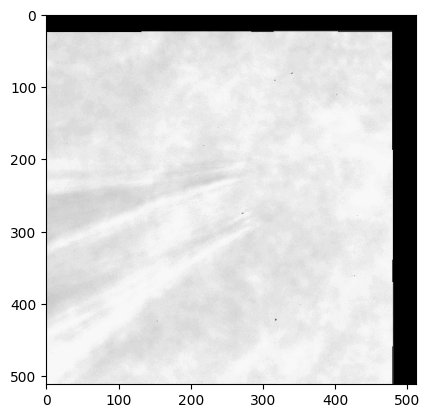

In [11]:
#visualize training set post transformation
rand = np.random.randint(0, len(train_images))


pre_transform = train_images[rand]
img = train_transforms(pre_transform)
plt.imshow(img.permute(1, 2, 0))

In [12]:
# train resnet18
num_epochs = 50
batch_size = 32
train_losses = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i in range(0, len(train_images), batch_size):
        #get batch of images and labels
        images = train_images[i:i+batch_size]
        labels = train_labels[i:i+batch_size]

        #apply transforms of images list
        images = [train_transforms(image).float() for image in images]

        #move to GPU
        images = torch.stack(images).to(device)
        labels = labels.long().to(device)

        #zero out gradients
        optimizer.zero_grad()

        #forward pass
        outputs = model(images)

        #calculate loss
        loss = criterion(outputs, labels)

        #backward pass
        loss.backward()

        #update weights
        optimizer.step()

        #calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print('predicted: ', predicted, 'labels: ', labels)

    #calculate loss
    train_losses.append(loss.item())

    #print loss and accuracy
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, loss.item(), (correct / total) * 100))

Epoch [1/50], Loss: 2.1397, Accuracy: 13.75%
Epoch [2/50], Loss: 1.7669, Accuracy: 27.21%
Epoch [3/50], Loss: 1.6057, Accuracy: 35.46%
Epoch [4/50], Loss: 1.1560, Accuracy: 41.68%
Epoch [5/50], Loss: 1.0838, Accuracy: 47.18%
Epoch [6/50], Loss: 0.9702, Accuracy: 52.24%
Epoch [7/50], Loss: 0.7670, Accuracy: 58.32%
Epoch [8/50], Loss: 0.6178, Accuracy: 64.98%
Epoch [9/50], Loss: 0.6193, Accuracy: 66.71%
Epoch [10/50], Loss: 0.7081, Accuracy: 63.68%
Epoch [11/50], Loss: 0.4219, Accuracy: 73.37%
Epoch [12/50], Loss: 0.4272, Accuracy: 76.12%
Epoch [13/50], Loss: 0.4029, Accuracy: 75.40%
Epoch [14/50], Loss: 0.4000, Accuracy: 73.81%
Epoch [15/50], Loss: 0.3521, Accuracy: 75.40%
Epoch [16/50], Loss: 0.2980, Accuracy: 77.42%
Epoch [17/50], Loss: 0.2361, Accuracy: 79.74%
Epoch [18/50], Loss: 0.2254, Accuracy: 80.61%
Epoch [19/50], Loss: 0.2577, Accuracy: 80.32%
Epoch [20/50], Loss: 0.3438, Accuracy: 77.86%
Epoch [21/50], Loss: 0.4542, Accuracy: 78.00%
Epoch [22/50], Loss: 0.2260, Accuracy: 78.2

Test Accuracy of the model on the test images: 71.09826589595376 %


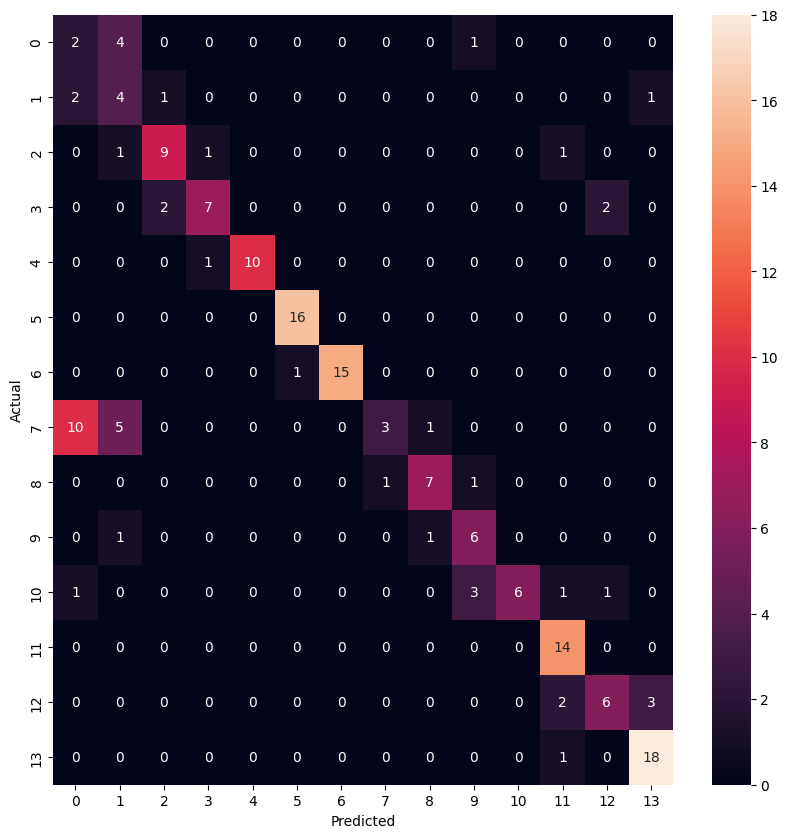

In [13]:
#create confusion matrix
model = model.to(device)
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    for i in range(0, len(test_images), batch_size):
        #get batch of images and labels
        images = test_images[i:i+batch_size]
        labels = test_labels[i:i+batch_size]

        #move to GPU
        images = images.float().to(device)
        labels = labels.long().to(device)

        #forward pass
        outputs = model(images)

        #calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())

    #print loss and accuracy
    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

from sklearn.metrics import confusion_matrix
import seaborn as sns

#show confusion matrix
cm = confusion_matrix(test_labels.cpu().numpy(), predictions)
plt.figure(figsize=(10,10))

sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Predicted:  7
Actual:  7


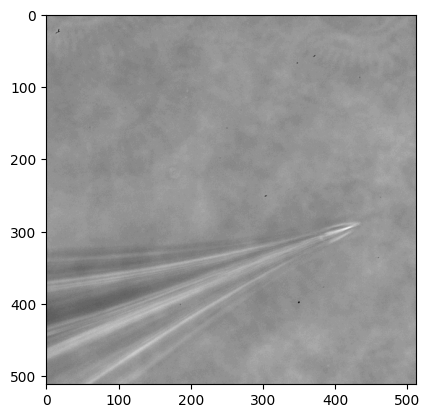

In [25]:
#display a random image and its prediction
showIncorrect = False
showType = 0

while True:
    rand = np.random.randint(0, len(test_images))
    if predictions[rand] != test_labels[rand].cpu().numpy() and showIncorrect and (showType == test_labels[rand].cpu().numpy() or showType == -1):
        break
    if predictions[rand] == showType and showType != -1 and not showIncorrect:
        break
plt.imshow(test_images[rand].permute(1, 2, 0))
print("Predicted: ", predictions[rand])
print("Actual: ", test_labels[rand].cpu().numpy())

In [15]:
#save a model checkpoint
torch.save(model.state_dict(), 'pipetteFocusNet.ckpt')

#export model as onnx for opencv dnn
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')
torch.onnx.export(model, dummy_input, "pipetteFocusNet.onnx", verbose=True)

Exported graph: graph(%input.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(14, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(14, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_203 : Float(64, strides=[1], requires_grad=0, device=cuda:0

In [16]:
#test prediction time on CPU
cpu_model = model.to('cpu')
dummy_input = torch.randn(1, 3, 512, 512, device='cpu')
%timeit cpu_model(dummy_input)

59.8 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
